# This notebook is for the Fair-Shapely experiment

In [107]:
%reload_ext autoreload
%autoreload 2

### 1. Import libraries

In [108]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

### 2. Import dataset

In [109]:
from src.data.unified_dataloader import load_dataset

a, processed_german_credit = load_dataset('german_credit')
# _, processed_uci = load_dataset('uci')

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64


In [110]:
processed_german_credit.head(3)

,Age,sex,Credit amount,Duration,Job_0,Job_1,Job_2,Job_3,Housing_free,Housing_own,...,Checking account_rich,Purpose_business,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,Risk
0,2.766456,0,-0.745131,-1.236478,0,0,1,0,0,1,...,0,0,0,0,0,0,1,0,0,0
1,-1.191404,1,0.949817,2.248194,0,0,1,0,0,1,...,0,0,0,0,0,0,1,0,0,1
2,1.183312,0,-0.416562,-0.738668,0,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0


### 3. Split label/unlabel data, split train/test data.

In [111]:
'''UCI dataset'''
# df = processed_uci.copy()
# X = df.drop('income', axis=1)
# y = df['income']

'''German Credit dataset'''
df = processed_german_credit.copy()
X = df.drop('Risk', axis=1)
y = df['Risk']

# into 70% training and 30% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=25) 
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')

X_train shape: (700, 26)
X_test shape: (300, 26)


### 4. Train the original model

In [112]:
model = XGBClassifier()  # 可以替换为 RandomForestClassifier() 等其他模型
model.fit(X_train,y_train)

# 预测和评估
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.6766666666666666


In [113]:
X_train['sex'].value_counts()

sex
0    479
1    221
Name: count, dtype: int64

In [114]:
'''把X_train分成majority和minority两个部分'''

male_condition = X_train['sex'] == 0
X_train_majority = X_train[male_condition]
y_train_majority = y_train[male_condition]

female_condition = X_train['sex'] == 1
X_train_minority = X_train[female_condition]
y_train_minority = y_train[female_condition]

### 5. Evaluate the performance of original model

In [115]:
from src.attribution.oracle_metric import perturb_numpy_ver
from src.attribution import FairnessExplainer
sen_att_name = ["sex"]
sen_att = [X_train.columns.get_loc(name) for name in sen_att_name]
priv_val = [1]
unpriv_dict = [list(set(X_train.values[:, sa])) for sa in sen_att]
for sa_list, pv in zip(unpriv_dict, priv_val):
    sa_list.remove(pv)
# print(f'sen_att_name:{sen_att_name}')
# print(f'sen_att:{sen_att}') # index of sensitive attribute
# print(f'priv_val:{priv_val}') # privileged value
# print(f'unpriv_dict:{unpriv_dict}') # unprivileged value(all values in the sensitive attribute, except the privileged value)



''' 
计算DR value的函数
'''
def fairness_value_function(sen_att, priv_val, unpriv_dict, X, model):
    X_disturbed = perturb_numpy_ver(
        X=X,
        sen_att=sen_att,
        priv_val=priv_val,
        unpriv_dict=unpriv_dict,
        ratio=1.0,
    )
    fx = model.predict_proba(X)[:, 1]
    fx_q = model.predict_proba(X_disturbed)[:, 1]
    return np.mean(np.abs(fx - fx_q))
original_test_DR = fairness_value_function(sen_att, priv_val, unpriv_dict, X_test.values, model)
print(f'original_test_DR: {original_test_DR}')
original_train_DR = fairness_value_function(sen_att, priv_val, unpriv_dict, X_train.values, model)
print(f'original_train_DR: {original_train_DR}')


original_test_DR: 0.05330166965723038
original_train_DR: 0.044362135231494904


### 5. 把female和male匹配，（或者male和female匹配），然后进行修改，重新训练

3. 将X_train_minority与X_train_majority进行匹配
4. 使用fairshap, 从X_train_majority中找到合适的值替换X_train_minority中的数据
5. 计算出varphi和q
shapely value中大于0.1的值的个数有: 26


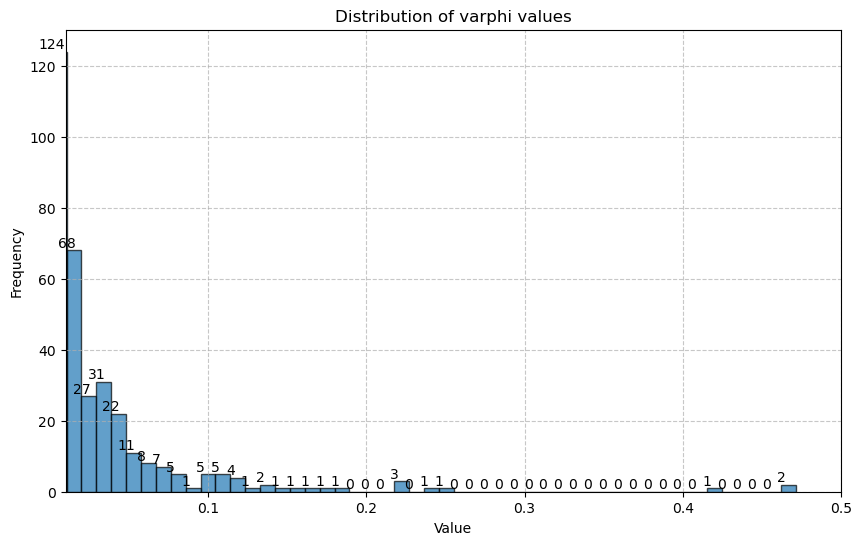

6. 用新数据重新训练，并且评估


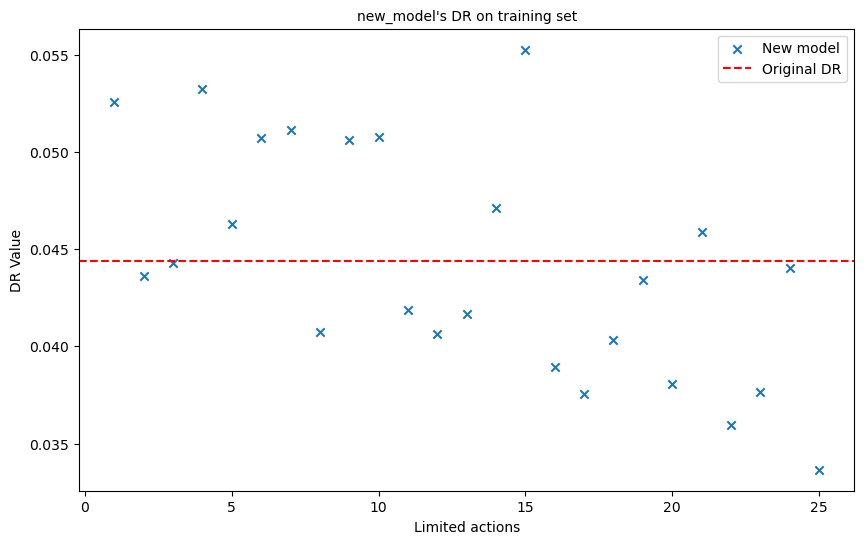

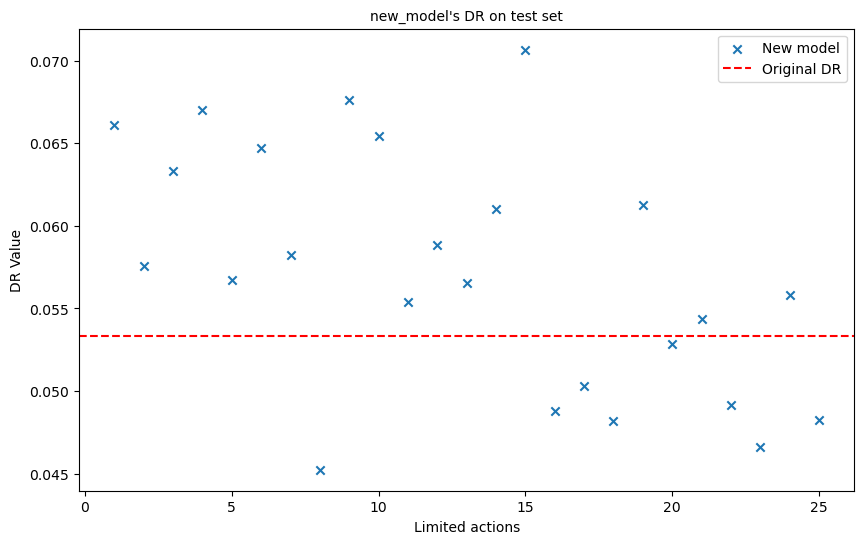

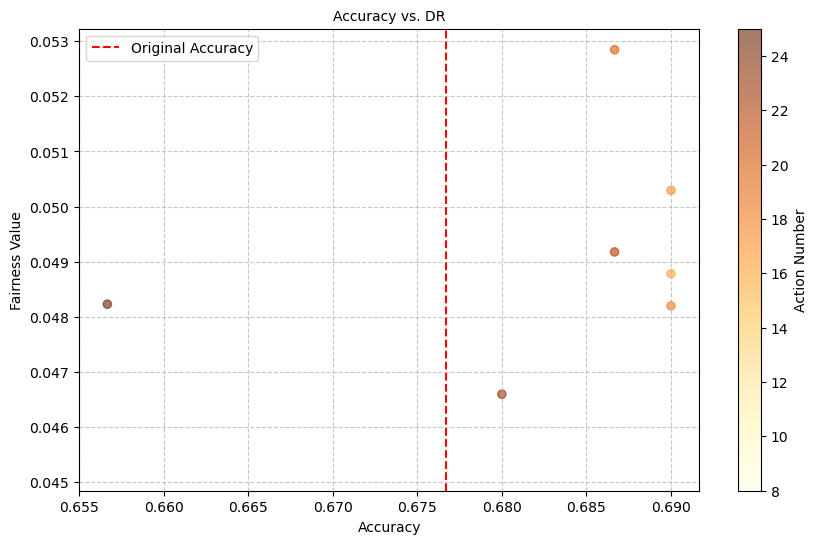

([0.06609437,
  0.057557996,
  0.06332363,
  0.06699586,
  0.056705195,
  0.06471713,
  0.05825531,
  0.045229364,
  0.06761157,
  0.065450214,
  0.055395305,
  0.058836263,
  0.05653483,
  0.060993984,
  0.07066566,
  0.04878304,
  0.05029482,
  0.04820184,
  0.061247636,
  0.052845065,
  0.05435921,
  0.049178638,
  0.04659928,
  0.05582302,
  0.04823103],
 [(0.045229364, 0.6766666666666666, 8),
  (0.04878304, 0.69, 16),
  (0.05029482, 0.69, 17),
  (0.04820184, 0.69, 18),
  (0.052845065, 0.6866666666666666, 20),
  (0.049178638, 0.6866666666666666, 22),
  (0.04659928, 0.68, 23),
  (0.04823103, 0.6566666666666666, 25)])

In [116]:
from src.experiments_approach2 import ExperimentNew

''' 改变minority group中的部分特征值'''

experiment = ExperimentNew(
                            model,
                            X_train_majority,
                            y_train_majority,
                            X_train_minority,
                            y_train_minority,
                            X_test,
                            y_test,
                            dataset_name='german_credit',
                            change_group = 'minority')
experiment.run_experiment()


3. 将X_train_majority与X_train_minority进行匹配
4. 使用fairshap, 从X_train_minority中找到合适的值替换X_train_majority中的数据
5. 计算出varphi和q
shapely value中大于0.1的值的个数有: 42


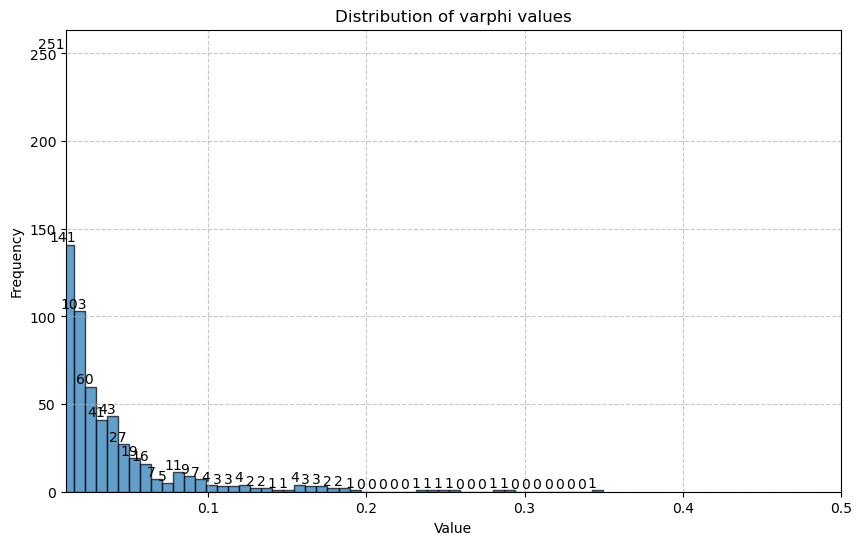

6. 用新数据重新训练，并且评估


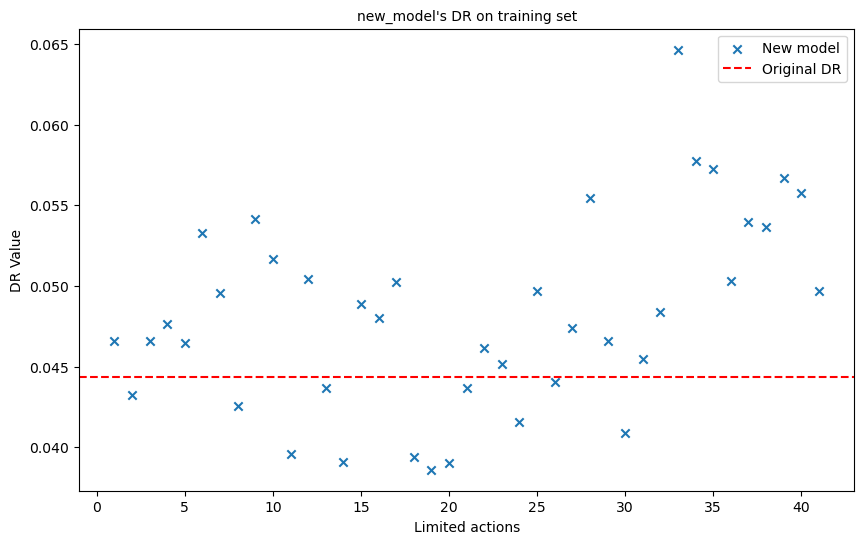

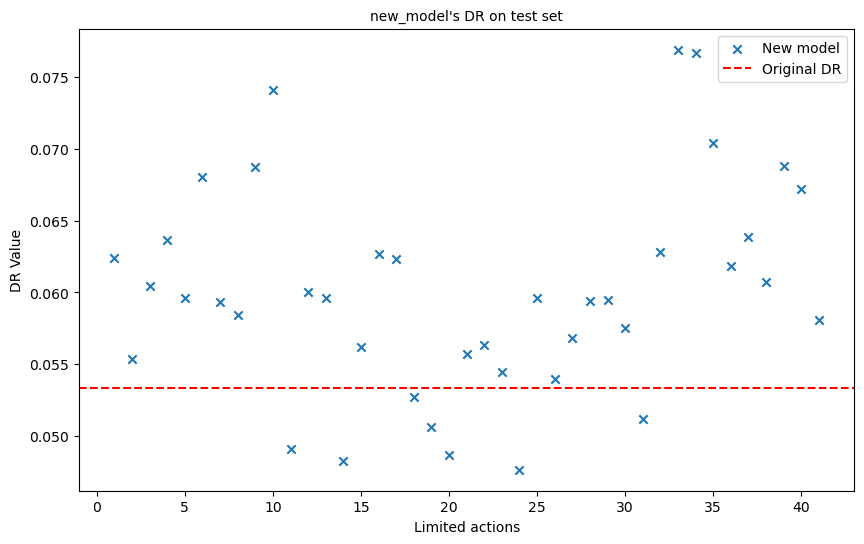

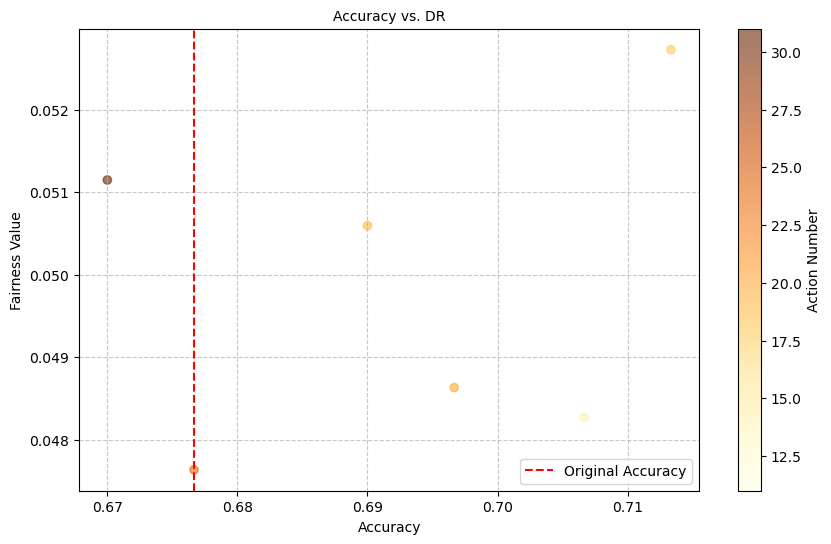

([0.062386133,
  0.055370133,
  0.06043335,
  0.063690186,
  0.05962443,
  0.06806935,
  0.05936311,
  0.05841357,
  0.06871455,
  0.07408281,
  0.04910325,
  0.060003206,
  0.059620857,
  0.048272017,
  0.0561669,
  0.06269184,
  0.062303793,
  0.052727368,
  0.050594132,
  0.048632614,
  0.055720102,
  0.05631201,
  0.05446013,
  0.047636405,
  0.059625182,
  0.05395541,
  0.056834754,
  0.05942641,
  0.059447836,
  0.05752983,
  0.05114839,
  0.062784635,
  0.07692546,
  0.07670416,
  0.07041395,
  0.061816443,
  0.06383409,
  0.060749736,
  0.0688223,
  0.06722698,
  0.05806268],
 [(0.04910325, 0.6766666666666666, 11),
  (0.048272017, 0.7066666666666667, 14),
  (0.052727368, 0.7133333333333334, 18),
  (0.050594132, 0.69, 19),
  (0.048632614, 0.6966666666666667, 20),
  (0.047636405, 0.6766666666666666, 24),
  (0.05114839, 0.67, 31)])

In [117]:
''' 改变majority group中的部分特征值'''
experiment2 = ExperimentNew(
                            model,
                            X_train_majority,
                            y_train_majority,
                            X_train_minority,
                            y_train_minority,
                            X_test,
                            y_test,
                            dataset_name='german_credit',
                            change_group = 'majority')
experiment2.run_experiment()

In [118]:
''' Experiment new

1. 从majority parity(此处男性)中随机选择30%, 50%, 70%的比例，作为将被替换的数据集X_train_replace_majority,剩余部分为X_train_rest_majority
2. 将X_train_minority与X_train_replace_majority进行匹配
3. 使用fairshap,把X_train_minority作为baseline dataset，找到X_train_replace_majority中需要替换的数据，假设总共需要替换n个数据点
4. (1,n,20)根据这些,分别计算替换(1,n)中不同个数的结果,把需要替换的数据替换到X_train_replace_majority中,得到X_train_replace_majority_new
5. 把X_train_replace_majority_new和X_train_rest_majority,还有X_train_minority合并,得到新的X_train_new，然后重新训练，得到新的模型model_new，计算新的DR值

----------   循环 30%, 50%, 70%的比例，以及不同的n值，得到DR值的变化  -------------------
'''

' Experiment new\n\n1. 从majority parity(此处男性)中随机选择30%, 50%, 70%的比例，作为将被替换的数据集X_train_replace_majority,剩余部分为X_train_rest_majority\n2. 将X_train_minority与X_train_replace_majority进行匹配\n3. 使用fairshap,把X_train_minority作为baseline dataset，找到X_train_replace_majority中需要替换的数据，假设总共需要替换n个数据点\n4. (1,n,20)根据这些,分别计算替换(1,n)中不同个数的结果,把需要替换的数据替换到X_train_replace_majority中,得到X_train_replace_majority_new\n5. 把X_train_replace_majority_new和X_train_rest_majority,还有X_train_minority合并,得到新的X_train_new，然后重新训练，得到新的模型model_new，计算新的DR值\n\n----------   循环 30%, 50%, 70%的比例，以及不同的n值，得到DR值的变化  -------------------\n'